<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Train-Test-Split and Bias and Variance

_Authors: Joseph Nelson (DC), Kevin Markham(DC)_

---

<a id="learning-objectives"></a>
<a id="learning-objectives"></a>
<a id="learning-objectives"></a>
### Learning Objectives
- Describe what error due to bias is and what error due to variance is
- Identify the bias-variance tradeoff
- Describe what overfitting and underfitting means in the context of model building
- Explain problems associated with over and underfitting
- Grasp why train, test split is necessary
- Explore kfolds, LOOCV, and three split methods

### Lesson Guide
- [Bias and Variance Trade-off](#bias-and-variance-trade-off)
	- [Bias? Variance?](#bias-variance)
	- [Exploring the Bias-Variance Tradeoff](#exploring-the-bias-variance-tradeoff)
	- [Brain and body weight mammal dataset](#brain-and-body-weight-mammal-dataset)
	- [Making a prediction](#making-a-prediction)
- [Making a prediction from a sample](#making-a-prediction-from-a-sample)
	- [Let's try something completely different](#lets-try-something-completely-different)
- [Balancing Bias and Variance](#balancing-bias-and-variance)
- [Train-test-split](#train-test-split)
	- [Evaluation procedure #1: Train and test on the entire dataset (do not do this)](#evaluation-procedure--train-and-test-on-the-entire-dataset-do-not-do-this)
	- [Problems with training and testing on the same data](#problems-with-training-and-testing-on-the-same-data)
	- [Evaluation procedure #2: Train/test split](#evaluation-procedure--traintest-split)
	- [Comparing test performance with a null baseline](#comparing-test-performance-with-a-null-baseline)
- [K-folds cross-validation](#k-folds-cross-validation)
	- [Leave-one-out-cross-validation](#leave-one-out-cross-validation)
	- [Intro to cross validation with the Boston data](#intro-to-cross-validation-with-the-boston-data)
- [Three way data split](#three-way-data-split)
	- [Additional Resources](#additional-resources)


<a id="bias-and-variance-trade-off"></a>
## Bias and Variance Trade-off
---

**Bias** is error due to the difference between the correct model and our predicted value

**Variance** is the error due to the variability of a model for a given data point

As model complexity **increases**, bias **decreases**

As model complexity **increases**, variance **increases**

<a id="bias-variance"></a>
### Bias? Variance?

**Conceptual Definitions**
- Bias – Error that results from the correct value and
the predicted value within our model
  - Roughly, whether our model aims on target or not.
- Variance – Error due to the variability of a model
prediction for a given data point
  - Roughly, whether our model is reliable.

![](./assets/images/biasVsVarianceImage.png)

- Visually, we are building a
model where the bulls-eye is
the goal
- Each individual hit is one
prediction based on our model
- Critically, the success of our
model (low variance, low bias)
depends on the training data
present 

**Mathematically, we are explaining a linear relationship dependent on some function**
- The error of our prediction is equal to the
true outcome and our predicted outcome
- This can be decomposed into two parts: the
bias and the variance:

<a id="exploring-the-bias-variance-tradeoff"></a>
### Exploring the Bias-Variance Tradeoff

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# allow plots to appear in the notebook
%matplotlib inline

<a id="brain-and-body-weight-mammal-dataset"></a>
### Brain and body weight mammal dataset

This is a [dataset](http://people.sc.fsu.edu/~jburkardt/datasets/regression/x01.txt) of the average weight of the body and the brain for 62 mammal species. Let's read it into pandas and take a quick look:

In [2]:
path = r'./assets/dataset/mammals.txt'
cols = ['brain','body']
mammals = pd.read_table(path, sep='\t', names=cols, header=0)
mammals.head()

,brain,body
0,3.385,44.5
1,0.480,15.5
2,1.350,8.1
3,465.000,423.0
4,36.330,119.5


In [3]:
mammals.describe()

,brain,body
count,62.000000,62.000000
mean,198.789984,283.134194
std,899.158011,930.278942
min,0.005000,0.140000
25%,0.600000,4.250000
50%,3.342500,17.250000
75%,48.202500,166.000000
max,6654.000000,5712.000000


We're going to focus on a smaller subset in which the body weight is less than 200:

In [4]:
# only keep rows in which the body weight is less than 200
mammals = mammals[mammals.body < 200]
mammals.shape

(51, 2)

We're now going to pretend that there are only 51 mammal species in existence. In other words, we are pretending that this is the entire dataset of brain and body weights for **every known mammal species**.

Let's create a scatterplot (using [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/)) to visualize the relationship between brain and body weight:

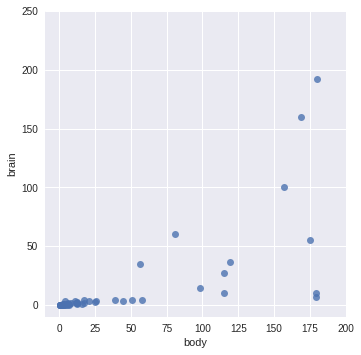

In [5]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, fit_reg=False);
sns.plt.xlim(-10, 200);
sns.plt.ylim(-10, 250);

There appears to be a relationship between brain and body weight for mammals.

<a id="making-a-prediction"></a>
### Making a prediction

<a id="linear-regression-quick-review"></a>
#### Linear regression quick review

![](./assets/images/linear-residuals.png)

Now let's pretend that a **new mammal species** is discovered. We measure the body weight of every member of this species that we can find, and calculate an **average body weight of 100**. We want to **predict the average brain weight** of this species (rather than measuring it directly). How might we do this?

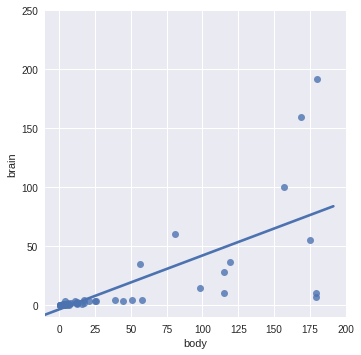

In [6]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None);
sns.plt.xlim(-10, 200);
sns.plt.ylim(-10, 250);

We drew a straight line that appears to best capture the relationship between brain and body weight. So, we might predict that our new species has a brain weight of about 45, since that's the approximate y value when x=100.

This is known as a "linear model" or a "linear regression model."

<a id="making-a-prediction-from-a-sample"></a>
## Making a prediction from a sample

Earlier, I said that this dataset contained every known mammal species. That's very convenient, but **in the real world, all you ever have is a sample of data**. A more realistic situation would be to only have brain and body weights for (let's say) half of the 51 known mammals.

When that new mammal species (with a body weight of 100) is discovered, we still want to make an accurate prediction for the brain weight, but this task might be more difficult since we don't have all of the data that we would ideally like to have.

Let's simulate this situation by assigning each of the 51 observations to **either universe 1 or universe 2**:

In [7]:
# set a random seed for reproducibility
np.random.seed(12345)

# randomly assign every observation to either universe 1 or universe 2
mammals['universe'] = np.random.randint(1, 3, len(mammals))
mammals.head()

,brain,body,universe
0,3.385,44.5,1
1,0.480,15.5,2
2,1.350,8.1,2
4,36.330,119.5,2
5,27.660,115.0,1


**Important:** We only live in one of the two universes. Both universes have 51 known mammal species, but each universe knows the brain and body weight for different species.

We can now tell Seaborn to create two plots, in which the left plot only uses the data from **universe 1** and the right plot only uses the data from **universe 2**:

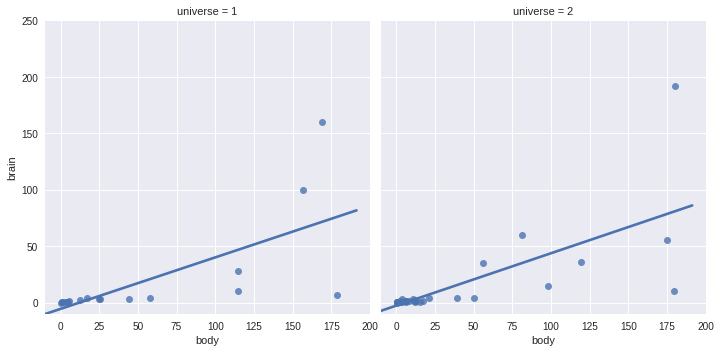

In [8]:
# col='universe' subsets the data by universe and creates two separate plots
sns.lmplot(x='body', y='brain', data=mammals, ci=None, col='universe');
sns.plt.xlim(-10, 200);
sns.plt.ylim(-10, 250);

The line looks pretty similar between the two plots, despite the fact that they used separate samples of data. In both cases, we would predict a brain weight of about 45.

It's easier to see the degree of similarity by placing them on the same plot:

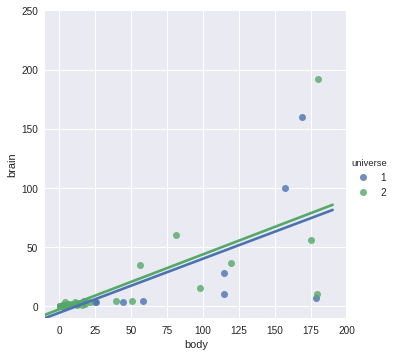

In [9]:
# hue='universe' subsets the data by universe and creates a single plot
sns.lmplot(x='body', y='brain', data=mammals, ci=None, hue='universe');
sns.plt.xlim(-10, 200);
sns.plt.ylim(-10, 250);

What was the point of this exercise? This was a visual demonstration of a high bias, low variance model:

- It's **high bias** because it doesn't fit the data particularly well.
- It's **low variance** because it doesn't change much depending on which observations happen to be available in that universe.

<a id="lets-try-something-completely-different"></a>
### Let's try something completely different

What would a **low bias, high variance** model look like? Let's try polynomial regression, with an eighth order polynomial:

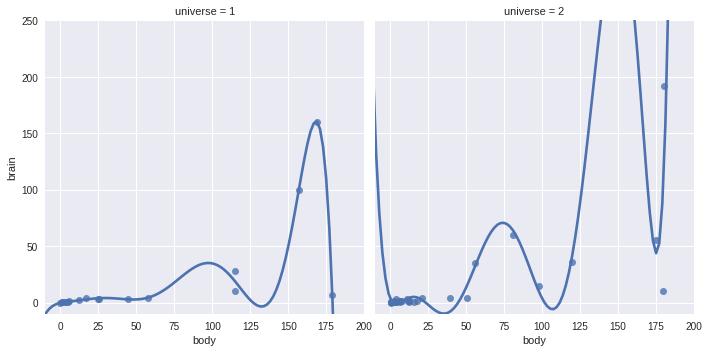

In [10]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, col='universe', order=8);
sns.plt.xlim(-10, 200);
sns.plt.ylim(-10, 250);

- It's **low bias** because the models match the data quite well!
- It's **high variance** because the models are widely different depending on which observations happen to be available in that universe. (For a body weight of 100, the brain weight prediction would be 40 in one universe and 0 in the other universe!)

<a id="balancing-bias-and-variance"></a>
## Balancing Bias and Variance
Can we find a middle ground?

Perhaps we can create a model that has **less bias than the linear model**, and **less variance than the eighth order polynomial**?

Let's try a second order polynomial instead:

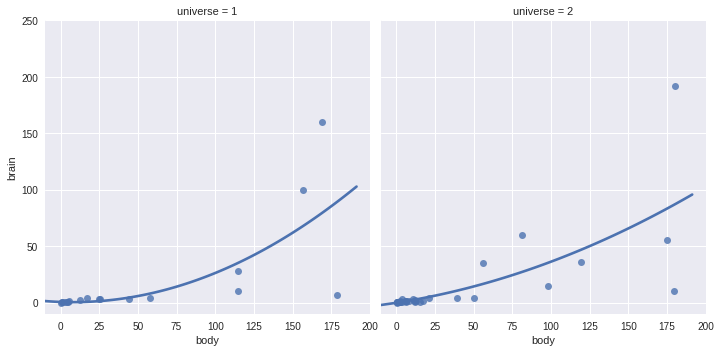

In [11]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, col='universe', order=2);
sns.plt.xlim(-10, 200);
sns.plt.ylim(-10, 250);

This seems better. In both the left and right plots, **it fits the data pretty well, but not too well**.

This is the essence of the **bias-variance tradeoff**: You are seeking a model that appropriately balances bias and variance, and thus will generalize to new data (known as "out-of-sample" data).

We want a model that best balances bias and variance. It
should match our training data well (moderate bias) yet be lowvariance
for out-of-sample data (moderate variance).

- Training error as a function of
complexity.
- Question: why do we even
care about variance if we
know we can generate a
more accurate model with
higher complexity?

<a id="train-test-split"></a>
## Train-test-split
---

We run into a problem where powerful models can perfect fit the data that they are trained on. These models are **low bias** and **high variance**. However, we can't observe the variance of a model directly, because we only know how it fits on the data we have and not all potential samples.

**Solution:** Create a procedure that **estimates** how well a model is likely to perform on out-of-sample data and use that to choose between models.

**Note:** These procedures can be used with **any machine learning model**.


**The holdout method: Train/Test Split**
- Training Set: Used to train the classifier
- Testing Set: Used to estimate the error rate of the trained classifier
- Advantages? Fast! Simple! Computationally inexpensive!
- Disadvantages? Eliminating data! Imperfect splits!

<a id="evaluation-procedure--train-and-test-on-the-entire-dataset-do-not-do-this"></a>
### Evaluation procedure #1: Train and test on the entire dataset (do not do this)

1. Train the model on the **entire dataset**.
2. Test the model on the **same dataset**, and evaluate how well we did by comparing the **predicted** response values with the **true** response values.

#### Load in the Boston data

In [12]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
boston = load_boston()

In [13]:
print boston.DESCR

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

#### Create and X and y variable to store the feature matrix and response from the Boston data.

In [14]:
# Create a dataframe for both parts of data, dont' forget to assign column names
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=['MEDV'])

#### Concatenate y and X, then overwrite the Boston variable.

In [15]:
boston = pd.concat([y, X], axis=1)

#### Perform basic EDA to make sure the data is in order.

In [16]:
boston.isnull().sum()

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [17]:
boston.dtypes

MEDV       float64
CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

In [18]:
boston.describe()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,9.197104,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,21.200000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,25.000000,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,50.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


#### Prepare a feature matrix, Xm and reponse, y,  for sklearn

In [19]:
# create feature matrix (X)
feature_cols = boston.columns.drop(['MEDV'])
X = boston[feature_cols]
# create response vector (y)
y = boston.MEDV

#### Import linear regression, instantiate, fit, and  preview predictions.

In [20]:
# import the class
from sklearn.linear_model import LinearRegression

# instantiate the model
lr = LinearRegression()

# train the model on the entire dataset
lr.fit(X, y)

# predict the response values for the observations in X ("test the model")
lr.predict(X)

array([ 30.00821269,  25.0298606 ,  30.5702317 ,  28.60814055,
        27.94288232,  25.25940048,  23.00433994,  19.5347558 ,
        11.51696539,  18.91981483,  18.9958266 ,  21.58970854,
        20.90534851,  19.55535931,  19.2837957 ,  19.30000174,
        20.52889993,  16.9096749 ,  16.17067411,  18.40781636,
        12.52040454,  17.67104565,  15.82934891,  13.80368317,
        15.67708138,  13.3791645 ,  15.46258829,  14.69863607,
        19.54518512,  20.87309945,  11.44806825,  18.05900412,
         8.78841666,  14.27882319,  13.69097132,  23.81755469,
        22.34216285,  23.11123204,  22.91494157,  31.35826216,
        34.21485385,  28.0207132 ,  25.20646572,  24.61192851,
        22.94438953,  22.10150945,  20.42467417,  18.03614022,
         9.10176198,  17.20856571,  21.28259372,  23.97621248,
        27.65853521,  24.0521088 ,  15.35989132,  31.14817003,
        24.85878746,  33.11017111,  21.77458036,  21.08526739,
        17.87203538,  18.50881381,  23.9879809 ,  22.54

#### Store the predicted response values.

In [21]:
y_pred = lr.predict(X)

To evaluate a model, we also need an **evaluation metric:**

- Numeric calculation used to **quantify** the performance of a model
- Appropriate metric depends on the **goals** of your problem

Most common choices for regression problems:

- **R-squared**: Percentage of variation explain by the model ("reward function" since higher is better)
- **Mean Squared Error**: Average squared distance between the prediction and the correct answer ("loss function" since lower is better)

In this case, we'll use mean squared error since it is more interpretable in a prediction context.

#### Compute mean squared error using a function from metrics

In [22]:
from sklearn import metrics
print(metrics.mean_squared_error(y, y_pred))

21.8977792177


This is known as **training mean squared error** because we are evaluating the model on the same data we used to train the model.

<a id="problems-with-training-and-testing-on-the-same-data"></a>
### Problems with training and testing on the same data

- Goal is to estimate likely performance of a model on **out-of-sample data**
- But, maximizing training mean squared error rewards **overly complex models** that won't necessarily generalize
- Unnecessarily complex models **overfit** the training data:
    - Will do well when tested using the in-sample data
    - May do poorly on out-of-sample data
    - Learns the "noise" in the data rather than the "signal"
    - From Quora: [What is an intuitive explanation of overfitting?](http://www.quora.com/What-is-an-intuitive-explanation-of-overfitting/answer/Jessica-Su)

**Thus, training MSE is not a good estimate of out-of-sample MSE.**

<a id="evaluation-procedure--traintest-split"></a>
### Evaluation procedure #2: Train/test split

1. Split the dataset into two pieces: a **training set** and a **testing set**.
2. Train the model on the **training set**.
3. Test the model on the **testing set**, and evaluate how well we did.

What does this accomplish?

- Model can be trained and tested on **different data** (we treat testing data like out-of-sample data).
- Response values are known for the testing set, and thus **predictions can be evaluated**.

This is known as **testing Mean Squared Error** because we are evaluating the model on an independent "test set" that was not used during model training.

**Testing MSE is a better estimate of out-of-sample performance than training MSE.**

#### Before we dive into train_test_split, lets understanding "unpacking" syntax.

In [23]:
def min_max(nums):
    smallest = min(nums)
    largest = max(nums)
    return [smallest, largest, 5]

In [24]:
min_and_max = min_max([1, 2, 3])
print(min_and_max)
print(type(min_and_max))

[1, 3, 5]
<type 'list'>


In [25]:
five, the_min, the_max = min_max([1, 2, 3])
print(the_min)
print(five)

3
1


#### Understanding the `train_test_split` function

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [27]:
# before splitting
print(X.shape)

# after splitting
print(X_train.shape)
print(X_test.shape)

(506, 13)
(379, 13)
(127, 13)


In [28]:
# before splitting
print(y.shape)

# after splitting
print(y_train.shape)
print(y_test.shape)

(506,)
(379,)
(127,)


![train_test_split](./assets/images/train_test_split.png)

#### Understanding the `random_state` parameter

The random_state is a pseudo-random number allowing us to reproduce our results every time we run them, but making it impossible to predict what are exact results will be if we chose a new random_state.

In [29]:
# WITHOUT a random_state parameter
X_train, X_test, y_train, y_test = train_test_split(X, y)

# print the first element of each object
print(X_train.head(1))


        CRIM   ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
313  0.26938  0.0    9.9   0.0  0.544  6.266  82.8  3.2628  4.0  304.0   

     PTRATIO       B  LSTAT  
313     18.4  393.39    7.9  


In [30]:
# WITH a random_state parameter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# print the first element of each object
print(X_train.head(1))
print(X_test.head(1))
print(y_train.head(1))
print(y_test.head(1))

        CRIM   ZN  INDUS  CHAS    NOX    RM   AGE     DIS  RAD    TAX  \
502  0.04527  0.0  11.93   0.0  0.573  6.12  76.7  2.2875  1.0  273.0   

     PTRATIO      B  LSTAT  
502     21.0  396.9   9.08  
        CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
307  0.04932  33.0   2.18   0.0  0.472  6.849  70.3  3.1827  7.0  222.0   

     PTRATIO      B  LSTAT  
307     18.4  396.9   7.53  
502    20.6
Name: MEDV, dtype: float64
307    28.2
Name: MEDV, dtype: float64


#### Introduce Patsy

We will make one more modification. Patsy is a library that allows you to quickly do simple transformations of data in a style similar to R.

Rather than manually creating X and y, we will use the dmatricies function from Patsy to create the matricies and allow us to explore the effect of changing features on training and testing error.

In [31]:
import patsy

#### STEP 1: split X and y into training and testing sets (using random_state for reproducibility)

In [32]:
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=boston, return_type="dataframe")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

#### STEP 2: train the model on the training set (using K=1)

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### STEP 3: test the model on the testing set, and check the accuracy

In [34]:
y_pred = lr.predict(X_test)
print(metrics.mean_squared_error(y_train, lr.predict(X_train)))
print(metrics.mean_squared_error(y_test, y_pred))

38.9690557877
42.0017522149


![Bias-variance tradeoff](./assets/images/bias_variance.png)

#### Go back to step 1 and try adding new variables and transformations.

- **Training error** decreases as model complexity increases (lower value of K)
- **Testing error** is minimized at the optimum model complexity

<a id="comparing-test-performance-with-a-null-baseline"></a>
### Comparing test performance with a null baseline

When interpreting how predictive a model it's best to always compare it to a baseline using a dummy model, sometimes called a ZeroR model. A dummy model is simply using the mean, median, or most common value as prediction. This forms a benchmark to compare your model against and becomes especially important in classification where your null accuracy might be 95%.

#### Examine the baseline mean squared error using a null model
How does this compare to what we achieved with linear regression. Is our model making an actual improvement?

In [35]:
# Use .apply() to broadcast a mean for every prediction
print(metrics.mean_squared_error(y_test, y_test.apply(np.mean, broadcast=True)))

91.7227974456


<a id="k-folds-cross-validation"></a>
## K-folds cross-validation
---

Train test split gives as a nice inuition and tool, but it's a shame that we are tossing out a large chunk of our data for testing purposes.

**How can we use the maximum amount of our data points while still ensuring model** integrity?

1. Split our data into a number of different pieces (folds)
2. Train using k-1 folds for training and a different fold for testing
3. Average our model against EACH of those iterations
4. Choose our model and TEST it against the final fold

![](./assets/images/cross_validation_diagram.png)

<a id="leave-one-out-cross-validation"></a>
### Leave-one-out-cross-validation

A special case of k-fold cross-validation is leave-one-out-cross-validation. Rather than taking 5-10 folds we take a fold of size n - 1 and leave one observation to test. 

Typically, 5-10 fold cross-validaiton is recommended.

<a id="intro-to-cross-validation-with-the-boston-data"></a>
### Intro to cross validation with the Boston data

#### Create a cross valiation with 5 folds

In [36]:
from sklearn import model_selection

In [37]:
kf = model_selection.KFold(n_splits=5, shuffle=True)

In [38]:
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 31.8527819054
R2: 0.529650317715
Model 2
MSE: 49.2865683245
R2: 0.529736665485
Model 3
MSE: 34.7083355581
R2: 0.529608811175
Model 4
MSE: 33.7481901379
R2: 0.529981072809
Model 5
MSE: 52.0730562489
R2: 0.528034047468
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 40.333786435
Mean of R2 for all folds: 0.52940218293


In [39]:
from sklearn.model_selection import cross_val_score
kf = model_selection.KFold(n_splits=5, shuffle=True)
print np.mean(-cross_val_score(lr, X, y, cv=kf, scoring='neg_mean_squared_error'))
print np.mean(cross_val_score(lr, X, y, cv=kf))

40.3491431996
0.487960635798


While the cross validated approach here generated more overall error, which of the two approaches would predict new data more accurately: the single model or the cross validated, averaged one? Why?
Answer: this score will be lower with the single model in the case, but we're trading off bias error for generalized error

<a id="three-way-data-split"></a>
<a id="three-way-data-split"></a>
<a id="three-way-data-split"></a>
## Three way data split
---

The most common workflow is actually a combination of train-test-split and cross-validation. We take a train-test-split on our data right away and try not spend a lot of time using the test dataset. Instead we take our training data and tune our models using cross-validation. When we think we are done, we do one last test on the test data to to make sure we haven't accidently overfit to our training data.

Even with good evaluation procedures it is incredible easy to overfit our models by including features that will not be available during production or leak information about our testing data in other ways.

![](./assets/images/Train-Test-Split-CV.png)

- If model selection and true error estimates are to be computed simultaneously,
three disjoint data sets are best.
- Training set: a set of example used for learning – what parameters of the
classifier
- Validation set: a set of examples used to tune the parameters of the classifier
- Testing set: a set of examples used ONLY to assess the performance of the
fully-trained classifier
- Validation and testing must be separate data sets. Once you have the final
model set, you cannot do any additional tuning after testing.

1. Divide data into training, validation, testing sets
2. Select architecture (model type) and training parameters (k)
3. Train the model using the training set
4. Evaluate the model using the training set
5. Repeat 2-4 selecting different architectures (models) and tuning parameters
6. Select the best model
7. Assess the model with the final testing set

<a id="additional-resources"></a>
<a id="additional-resources"></a>
### Additional Resources
- http://scott.fortmann-roe.com/docs/BiasVariance.html
- https://courses.cs.washington.edu/courses/cse546/12wi/slides/
- http://www.win-vector.com/blog/2015/01/random-testtrain-split-is-not-alwaysenough/